## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [5]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [6]:
train, test = keras.datasets.cifar10.load_data()

In [7]:
## 資料前處理
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()
def preproc_x(x):
    x = x.astype("float32")
    x = x.reshape(x.shape[0],-1)
    x = scaler.fit_transform(x)
    return x

def preproc_y(y):
    y = keras.utils.to_categorical(y, num_classes=10)
    return y   

In [8]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [9]:
"""
建立你的神經網路
"""
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization

def build_mlp(input_dim, layer_output_units, output_units, regularizer=None, dropout_ratio=None, isBN=False):
    model = Sequential()
    for i, untis in enumerate(layer_output_units):  
        if i == 0:
            model.add(Dense(units=untis, 
                            input_dim=input_dim,
                            kernel_initializer='normal',
                            kernel_regularizer=regularizer, 
                            activation='relu'))
            if isBN:
                model.add(BatchNormalization())
        else:
            model.add(Dense(units=untis,
                            kernel_initializer='normal',
                            kernel_regularizer=regularizer, 
                            activation='relu'))
            if isBN:
                model.add(BatchNormalization())

    if dropout_ratio:
        model.add(Dropout(dropout_ratio))
        
    model.add(Dense(units=output_units,
                kernel_initializer='normal', 
                activation='softmax'))
    return model  

In [24]:
"""
訓練模型
"""
def complie_train_model(model, optimizer, epochs, batch_size, x_train, y_train, x_test, y_test):
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer= optimizer)
    model.fit(x_train, y_train, 
          epochs= epochs, 
          batch_size=batch_size, 
          validation_data=(x_test, y_test), 
          shuffle=True)
    return model

In [11]:
"""
以視覺畫方式檢視訓練過程
"""
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def show_train_history(results):
    for i, result in enumerate(results):
        history = result["model"].history.history
        tag = "({})".format(result["tag"])
        df_acc = pd.DataFrame({"acc"+tag:history["acc"], "val_acc"+tag:history["val_acc"]})
        df_loss = pd.DataFrame({"loss"+tag:history["loss"], "val_loss"+tag:history["val_loss"]})
        if i ==0:
            df_acc_results = df_acc.copy()
            df_loss_results = df_loss.copy()
        else:
            df_acc_results= pd.concat([df_acc_results, df_acc], axis=1)
            df_loss_results= pd.concat([df_loss_results, df_loss], axis=1)    

    fig, ax = plt.subplots(1,2, figsize=(18,5))
    styles = ['bs-','ro-','y^-', 'g--']    
    g1 = df_acc_results.plot.line(style=styles, ax =ax[0])
    g1.set_xlabel("Epoch")
    g1.set_ylabel("Acc") 
    
    g2 = df_loss_results.plot.line(style=styles, ax =ax[1])
    g2.set_xlabel("Epoch")
    g2.set_ylabel("Loss") 
    return df_acc_results, df_loss_results

In [36]:
"""
設定超參數
"""
HYPER_PARAMS= [
{"EPOCHS": 10,
"BATCH_SIZE": 256,
"L2_EXP" :None,
"OPTIMIZER":"ADAM",
"LEARNING_RATE": 1e-3,
"DROPOUT_EXP": None,
"ISBN": False},

{"EPOCHS": 10,
"BATCH_SIZE": 256,
"L2_EXP" :1e-3,
"OPTIMIZER": "SGD",
"LEARNING_RATE": 1e-3,
"MOMENTUM": 0.95,
"DROPOUT_EXP": None,
"ISBN": True},
    
{"EPOCHS": 10,
"BATCH_SIZE": 256,
"L1L2_EXP" :1e-3,
"OPTIMIZER":"ADAM",
"LEARNING_RATE": 1e-3,
"MOMENTUM": None,
"DROPOUT_EXP": 0.25,
"ISBN": True}]

In [37]:
"""
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
results = list()

keras.backend.clear_session() # 把舊的 Graph 清掉

for i, params in enumerate(HYPER_PARAMS):
    print("the {} paramset {}".format(i, params))
    if "L1L2_EXP" in params:
        regularizer = keras.regularizers.l1_l2(l1=params["L1L2_EXP"], l2=params["L1L2_EXP"])
    elif "L2_EXP" in params:
        regularizer = keras.regularizers.l2(params["L2_EXP"])
    else:
        regularizer = None
    model = build_mlp(input_dim=x_train.shape[1], layer_output_units=[256,128], output_units=10, regularizer=regularizer, dropout_ratio=params["DROPOUT_EXP"], isBN=params["ISBN"])

    if "OPTIMIZER" in params and params["OPTIMIZER"] == "SGD":
        optimizer =  keras.optimizers.SGD(lr=params["LEARNING_RATE"], nesterov=True, momentum=params["MOMENTUM"])
    elif "OPTIMIZER" in params and params["OPTIMIZER"] == "ADAM":
        optimizer =  keras.optimizers.Adam(lr=params["LEARNING_RATE"])
    else:
        optimizer = None        
    model = complie_train_model(model, optimizer,params["EPOCHS"] , params["BATCH_SIZE"], x_train, y_train, x_test, y_test)
    
    results.append({"tag":i, "model":model})

the 0 paramset {'EPOCHS': 10, 'BATCH_SIZE': 256, 'L2_EXP': None, 'OPTIMIZER': 'ADAM', 'LEARNING_RATE': 0.001, 'DROPOUT_EXP': None, 'ISBN': False}
Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 18s 370us/step - loss: nan - acc: 0.0999 - val_loss: nan - val_acc: 0.1000
Epoch 2/10
50000/50000 [==============================] - 16s 317us/step - loss: nan - acc: 0.1000 - val_loss: nan - val_acc: 0.1000
Epoch 3/10
50000/50000 [==============================] - 16s 325us/step - loss: nan - acc: 0.1000 - val_loss: nan - val_acc: 0.1000
Epoch 4/10
50000/50000 [==============================] - 16s 319us/step - loss: nan - acc: 0.1000 - val_loss: nan - val_acc: 0.1000
Epoch 5/10
50000/50000 [==============================] - 16s 321us/step - loss: nan - acc: 0.1000 - val_loss: nan - val_acc: 0.1000
Epoch 6/10
50000/50000 [==============================] - 16s 328us/step - loss: nan - acc: 0.1000 - val_loss: nan - val_acc: 0.1000
Epoch 

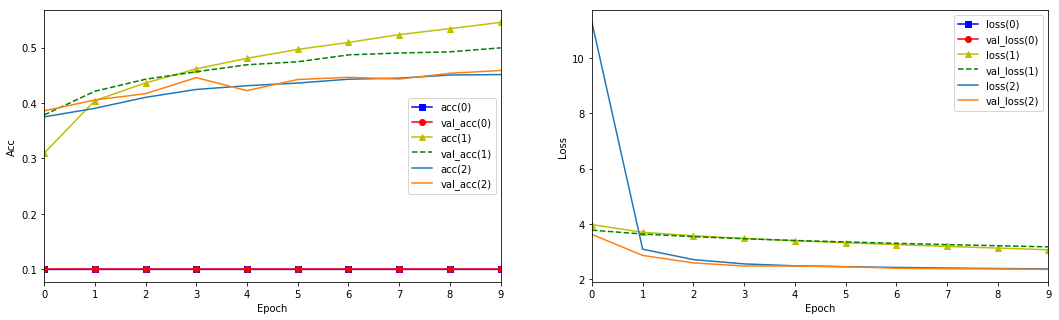

In [38]:
"""
將結果繪出
"""

import matplotlib.pyplot as plt
%matplotlib inline

df_acc_results, df_loss_results = show_train_history(results)